### This notebook is optionally accelerated with a GPU runtime.
### If you would like to use this acceleration, please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# MiDaS

*Author: Intel ISL*

**MiDaS models for computing relative depth from a single image.**

<img src="https://pytorch.org/assets/images/midas_samples.png" alt="alt" width="50%"/>


### Model Description

[MiDaS](https://arxiv.org/abs/1907.01341) computes relative inverse depth from a single image. The repository provides multiple models that cover different use cases ranging from a small, high-speed model to a very large model that provide the highest accuracy. The models have been trained on 10 distinct datasets using
multi-objective optimization to ensure high quality on a wide range of inputs.

### Dependencies

MiDaS depends on [timm](https://github.com/rwightman/pytorch-image-models). Install with

In [ ]:
pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 5.1 MB/s 


### Example Usage

Download an image from the PyTorch homepage

In [ ]:
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)

#filename='/content/resized_256_depth_20220514T001442.000Z.png'

('dog.jpg', <http.client.HTTPMessage at 0x7f37b6ee43d0>)

Load a model (see [https://github.com/intel-isl/MiDaS/#Accuracy](https://github.com/intel-isl/MiDaS/#Accuracy) for an overview)

In [ ]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Downloading: "https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-midas-2f21e586.pt" to /root/.cache/torch/hub/checkpoints/dpt_large-midas-2f21e586.pt


  0%|          | 0.00/1.28G [00:00<?, ?B/s]

Move model to GPU if available

In [ ]:
#Training the Midas Model on our data

dir(midas)

NameError: ignored

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU(approximate=none)
            (drop1): Dropout(p=0.0, inplace=F

Load transforms to resize and normalize the image for large or small model

In [ ]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Load image and apply transforms

In [ ]:
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

Predict and resize to original resolution

In [ ]:
with torch.no_grad():
    prediction = midas(input_batch)

    #Coming back to the size of the input
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

Show result

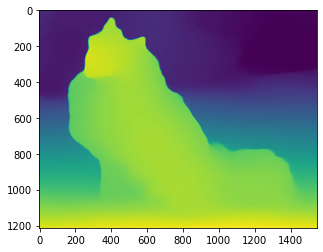

In [ ]:
plt.imshow(output)
# plt.show()

## Testing MIDAS on underwater images 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# NECESSARY EXTRA IMPORTS 

import os 
import time

In [ ]:
#NECESSARY PATH

images_path='/content/drive/MyDrive/images'
depth_maps_path='/content/drive/MyDrive/test_depth_maps'

In [ ]:
#LOAD DATA

def load_data(data_path, verbose=False):
    DATA_LOADED=False 
    print_every_n_loads=10
    images=[]
    ind=0
    t0=time.time()
    if not DATA_LOADED:
        print('Loading data...')
    for filename in os.listdir(data_path):
        img = mpimg.imread(os.path.join(data_path, filename))
        if img is not None:
            images.append(np.asarray(img))
            ind+=1
        if verbose:
            if ind%print_every_n_loads==0:
                print('nb of data loaded:', ind)
    print(f'Loaded data in: {time.time()-t0 } s')
    return images


In [ ]:

def plot_midas_results(image_path, depth_images_path, number_outputs):
  fig = plt.figure(figsize=(5*number_outputs,8.5)) #size of the output, in inches.

  i=0
  for filename in os.listdir(image_path):
      ax=plt.subplot(2, number_outputs, i+1)

      # LOADING + TRANSFORMS
      img = cv2.imread(image_path+'/'+filename)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      input_batch = transform(img).to(device)
      
      with torch.no_grad():
        prediction = midas(input_batch)

      #Coming back to the size of the input
      prediction = torch.nn.functional.interpolate( 
      prediction.unsqueeze(1),
      size=img.shape[:2],
      mode="bicubic",
      align_corners=False,
      ).squeeze()

      output = prediction.cpu().numpy()
      

      plt.imshow(img)
      
      if i == number_outputs//2:
          ax.set_title('Original Images')
      
      
      ax = plt.subplot(2, number_outputs, i + 1 + number_outputs)
      plt.imshow(output)

      
      
      if i == number_outputs//2:
          ax.set_title('Reconstructed depth maps')
      
      i+=1

      if i== number_outputs:
        return fig

  return fig


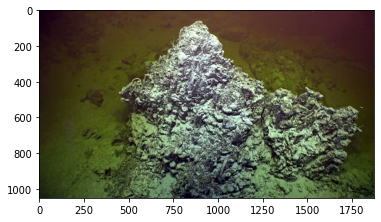

In [ ]:
img=cv2.imread('/content/drive/MyDrive/images/20220514T001724.000Z.jpg')
plt.imshow(img)

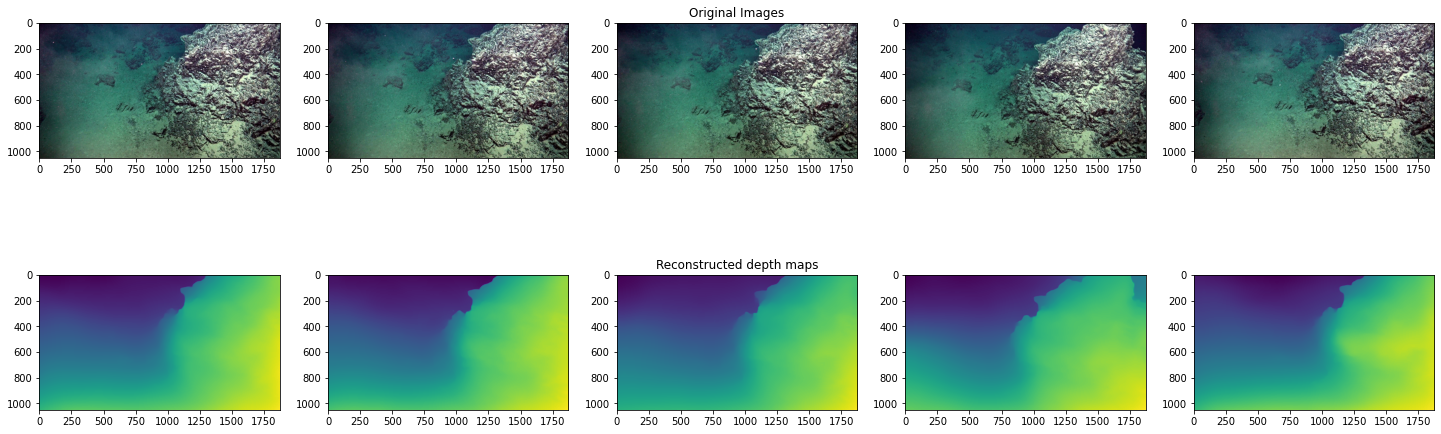

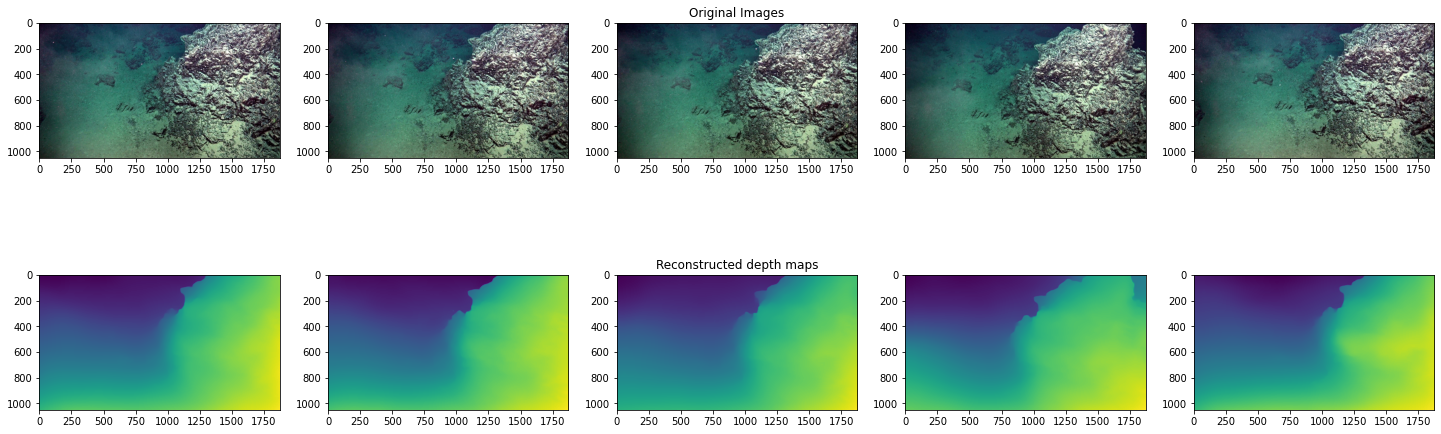

In [ ]:
plot_midas_results(images_path, depth_maps_path, 5)